# In this notebook
* The main ideia of this notebook is create an image classification model using CNNs with [PyTorch](https://pytorch.org/) framework, and [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset.
* The CIFAR-10 dataset contains 60_000 images, 50_000 for training and 10_000 for testing, divided into 10 classes ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog ', 'horse', 'ship', 'truck').

## 1. Importing Libraries

In [3]:
import itertools
from typing import Dict, List, Tuple

import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision
from helper_functions.plots import make_confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix
from torch import flatten, nn, optim
from torchvision import datasets, transforms
from tqdm.auto import tqdm

## 2. Setting Seeds

In [4]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

## 3. Downloading the dataset
First, we have to download the dataset in kaggle, and then we can use it in our notebook.

In [5]:
path = kagglehub.dataset_download("swaroopkml/cifar10-pngs-in-folders")

100%|██████████| 140M/140M [00:06<00:00, 22.9MB/s] 

Extracting files...


## 4. Loading the Dataset
The images and folders are as follows
```

cifar10
   |--train
   |    |--airplane
   |    |    |-- *.png
   |    |--automobile
   |    |    |-- *.png
        .
        .
        .
   |--test
   |    |--airplane
   |    |    |-- *.png
   |    |--automobile
   |    |    |-- *.png
        .
        .
        .
```

Here, we create the transforms, who will make some operations in images, like resize, convert to tensor and normalize

In [6]:
mean = 0.5
sd = 0.5

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((mean,), (sd,)),
])

Loading the dataset from the path, and applying the transform.
Here I pass the folder containing the images and create the dataset, the images in the `cifar10/train/` folder will be divided into training and validation.

And finally create the DataLoaders, which are generators, where the images are loaded into memory at each iteration, thus allowing us to use heavy datasets without the need to use all the memory (since we only load a piece of the dataset at a time).

In [7]:
train_path = f"{path}/cifar10/cifar10/train/"
test_path = f"{path}/cifar10/cifar10/test/"

train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

train, val = torch.utils.data.random_split(train_dataset, [45000, 5000])

train_dataloader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val, batch_size=32, shuffle=True)

In [8]:
classes = train_dataloader.dataset.dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [9]:
train_images, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_images.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 3, 32, 32])
Labels batch shape: torch.Size([32])


Plot some examples

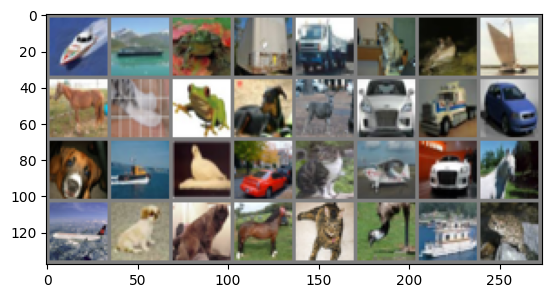

In [10]:
def imshow(img: torch.Tensor) -> None:
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# print images
imshow(torchvision.utils.make_grid(train_images))

In [11]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


## 5. Creating a model
For this project, we will use a [LeNet5](https://paperswithcode.com/method/lenet).

In [12]:
class LeNet5(nn.Module):
    def __init__(self, num_classes: int) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = flatten(x, 1)
        logit = self.classifier(x)
        return logit

In [13]:
model = LeNet5(num_classes=10)
model.to(device)
model

LeNet5(
  (features): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)

Number of params

In [14]:
def count_parameters(model: LeNet5) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


params = count_parameters(model)
print(f"The model has {params} params.")

The model has 62006 params.


## 6. Functions to train model

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [16]:
def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
) -> Tuple[float, float]:
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc


def test_step(
    model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, device: torch.device
) -> Tuple[float, float]:
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)

    # Adjust metrics to get average loss and accuracy per batch
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    return test_loss, test_acc


def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int,
    device: torch.device,
) -> Dict[str, List]:
    # Create empty results dictionary
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model=model, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, device=device
        )
        test_loss, test_acc = test_step(model=model, dataloader=test_dataloader, loss_fn=loss_fn, device=device)

        # Print out what's happening
        print(
            f"Epoch: {epoch + 1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

# 7. Train and save model

In [18]:
%%time
results = train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=25,
    device=device,
)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.0539 | train_acc: 0.2474 | test_loss: 1.8893 | test_acc: 0.3192
Epoch: 2 | train_loss: 1.7616 | train_acc: 0.3666 | test_loss: 1.6455 | test_acc: 0.4062
Epoch: 3 | train_loss: 1.5955 | train_acc: 0.4227 | test_loss: 1.5365 | test_acc: 0.4447
Epoch: 4 | train_loss: 1.4964 | train_acc: 0.4543 | test_loss: 1.4411 | test_acc: 0.4781
Epoch: 5 | train_loss: 1.4107 | train_acc: 0.4875 | test_loss: 1.3866 | test_acc: 0.5034
Epoch: 6 | train_loss: 1.3495 | train_acc: 0.5106 | test_loss: 1.3252 | test_acc: 0.5236
Epoch: 7 | train_loss: 1.2985 | train_acc: 0.5334 | test_loss: 1.2987 | test_acc: 0.5410
Epoch: 8 | train_loss: 1.2537 | train_acc: 0.5511 | test_loss: 1.2629 | test_acc: 0.5507
Epoch: 9 | train_loss: 1.2119 | train_acc: 0.5667 | test_loss: 1.2131 | test_acc: 0.5736
Epoch: 10 | train_loss: 1.1752 | train_acc: 0.5829 | test_loss: 1.1943 | test_acc: 0.5776
Epoch: 11 | train_loss: 1.1447 | train_acc: 0.5930 | test_loss: 1.1530 | test_acc: 0.5916
Epoch: 12 | train_l

In [19]:
path = "lenet_cifar10.pt"
torch.save(model, path)

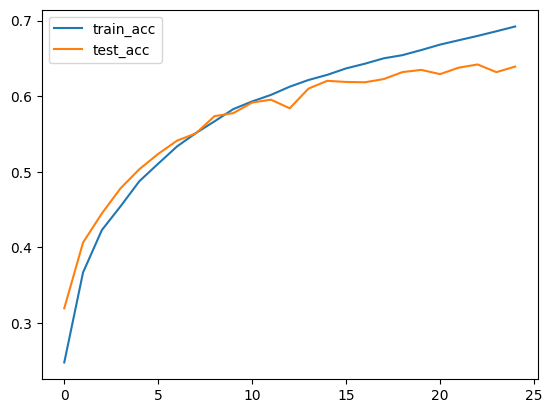

In [20]:
pd.DataFrame(results)[["train_acc", "test_acc"]].plot()
plt.show()

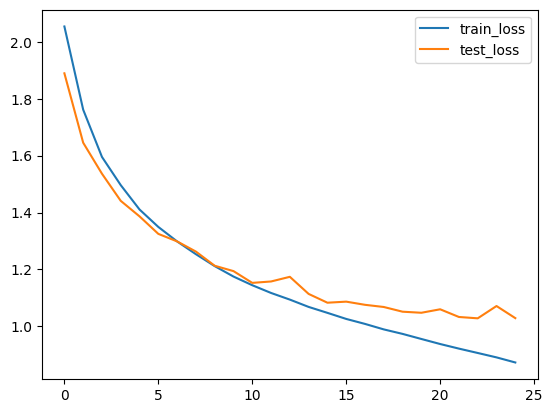

In [21]:
pd.DataFrame(results)[["train_loss", "test_loss"]].plot()
plt.show()

# 8. Evaluate

In [22]:
path = "lenet_cifar10.pt"

In [23]:
model = torch.load(path, weights_only=False)
model.eval()  # model in evaluation mode
model.to(device)

LeNet5(
  (features): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [24]:
%%time
labels = list()
predicted_labels = list()

for images_batch, labels_batch in tqdm(val_dataloader):
    with torch.inference_mode():
        predictions = model(images_batch.to(device))
        predicted_labels.extend(predictions)
        labels.extend(labels_batch)

  0%|          | 0/157 [00:00<?, ?it/s]

CPU times: user 1.39 s, sys: 76.9 ms, total: 1.47 s
Wall time: 1.47 s


In [25]:
predicted_labels = [int(np.argmax(i.cpu())) for i in predicted_labels]
labels = [int(i) for i in labels]

In [27]:
def make_confusion_matrix(
    y_true: list[int],
    y_pred: list[int],
    classes: list[str] | None = None,
    figsize: tuple[int, int] = (10, 10),
    text_size: int = 15,
    title: str = "Confusion Matrix",
) -> None:
    cm = confusion_matrix(y_true, y_pred).round(2)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    n_classes = cm.shape[0]

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm_norm, cmap="Blues")  # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(
        title=title,
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes),  # create enough axis slots for each class
        yticks=np.arange(n_classes),
        # axes will labeled with class names (if they exist) or ints
        xticklabels=labels,
        yticklabels=labels,
    )

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.0

    # Plot the text on each cell
    for i, j in itertools.product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
        plt.text(
            x=j,
            y=i,
            s=f"{cm_norm[i, j]:.2f}\n({cm[i, j]})",
            horizontalalignment="center",
            verticalalignment="center",
            color="white" if cm[i, j] > threshold else "black",
            size=text_size,
        )

Generating the confusion matrix with the results, this confusion matrix has the relative values ​​at the top and the absolute values ​​at the bottom (inside the parentheses).

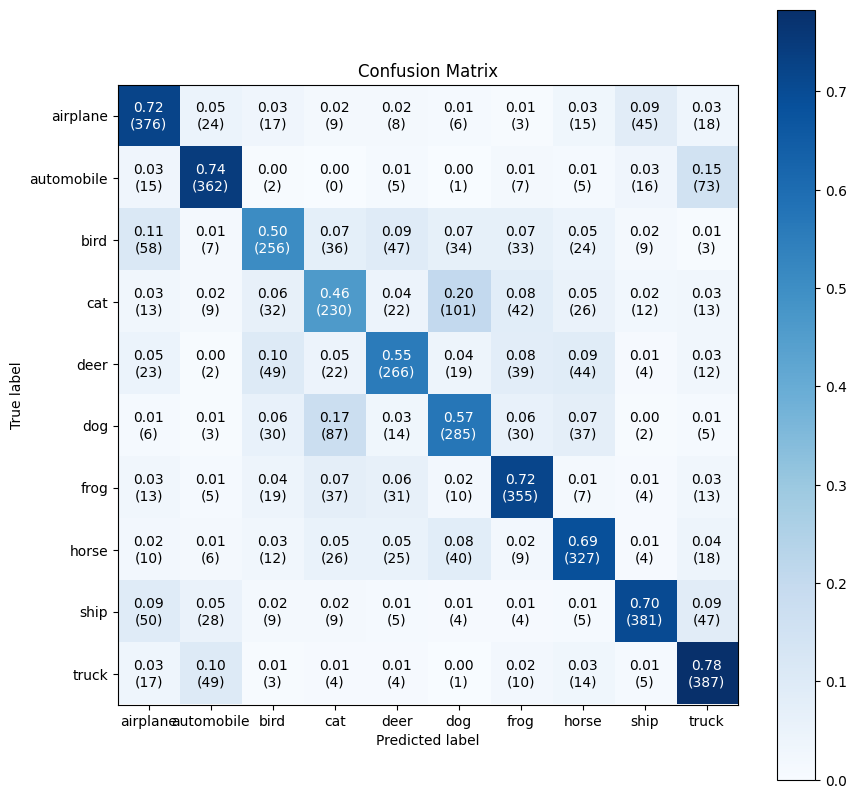

In [28]:
make_confusion_matrix(
    y_true=labels,
    y_pred=predicted_labels,
    classes=classes,
    figsize=(10, 10),
    text_size=10,
    title="Confusion Matrix",
)

In [29]:
acc = accuracy_score(y_true=labels, y_pred=predicted_labels)

print(f"Accuracy: {acc}")

Accuracy: 0.645


# 9. Final thoughts

* The accuracy of the test set was 64.6%, which I consider to be good accuracy, considering that there are 10 classes, that the images are in low resolution (32x32 pixels) and that the architecture (LeNet) used is a very simple architecture that has only 62,006 parameters (which is a very small number when compared to other architectures that have millions and bilions of parameters).
* The model was trained for 25 epochs, the accuracy and test loss values ​​could still improve a little, but since they were fluctuating a lot, it would be a little difficult to identify when the model was starting to overfit, and that is why I chose to train for only 25 epochs. 
* For problems such as image classification, I believe that we can achieve much better accuracy with some improvements, such as using other more robust architectures (such as ResNet50, MobileNet, EfficientNet), especially using transfer learning.